# Stock Price Classification Exercise

## Step 0: Import Libraries, Setup API's

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import quandl
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, auc

print("Libraries imported successfully!")

Libraries imported successfully!


## Step 1: Import Data

In [2]:
# Load data using pandas
stock_data = pd.read_csv("Data/ULTI.csv", index_col = 0, parse_dates=True)
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,153.279999,153.910004,151.679993,152.429993,152.429993,113900
2014-01-03,152.529999,154.059998,150.570007,151.880005,151.880005,125000
2014-01-06,152.210007,153.100006,150.809998,151.610001,151.610001,103300
2014-01-07,151.820007,155.000000,151.820007,153.410004,153.410004,135300
2014-01-08,153.619995,155.630005,153.130005,154.949997,154.949997,166100


## Step 2: Visualize data

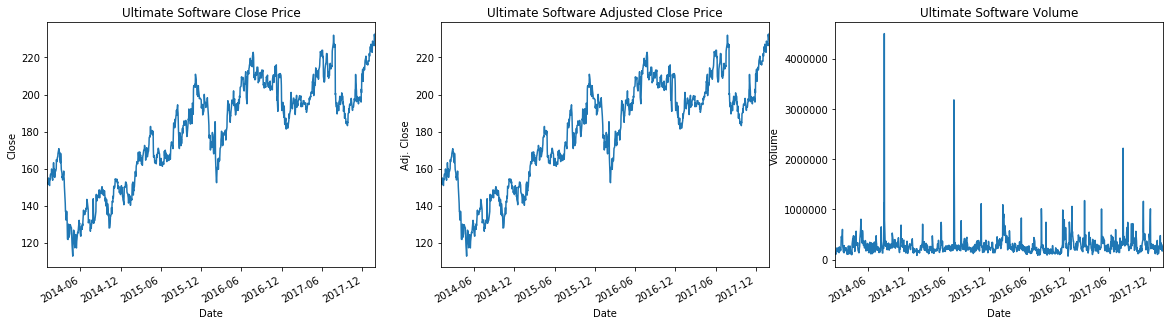

In [3]:
plt.figure(1, figsize=(20,5))

# Plot the close price
plt.subplot(131)
stock_data["Close"].plot()
plt.title("Ultimate Software Close Price")
plt.xlabel("Date")
plt.ylabel("Close")

# Plot the adjusted closing price
plt.subplot(132)
stock_data["Adj Close"].plot()
plt.title("Ultimate Software Adjusted Close Price")
plt.xlabel("Date")
plt.ylabel("Adj. Close")

# Plot the trading volume
plt.subplot(133)
stock_data["Volume"].plot()
plt.title("Ultimate Software Volume")
plt.xlabel("Date")
plt.ylabel("Volume")

plt.show()

## Step 3: Feature Engineering

### Step 3a: Define the target variable

The first step is to define the target variable. We are trying to build a model that can predict if the stock price is going to increase or decrease on the following day of trading based on the information we have at market close. The target variable will be defined as a binary variable indicating a day over day Increase (True) or day over day Decrease (False).

In [4]:
# Define target variable
stock_data["Next Day Change"] = stock_data["Close"]-stock_data["Close"].shift(-1)
stock_data["Target"] = stock_data["Next Day Change"].shift(-1)>0

stock_data.head()

,Open,High,Low,Close,Adj Close,Volume,Next Day Change,Target
Date,,,,,,,,
2014-01-02,153.279999,153.910004,151.679993,152.429993,152.429993,113900,0.549988,True
2014-01-03,152.529999,154.059998,150.570007,151.880005,151.880005,125000,0.270004,False
2014-01-06,152.210007,153.100006,150.809998,151.610001,151.610001,103300,-1.800003,False
2014-01-07,151.820007,155.000000,151.820007,153.410004,153.410004,135300,-1.539993,True
2014-01-08,153.619995,155.630005,153.130005,154.949997,154.949997,166100,2.770004,True


### Step 3b: Bollinger Bands

The first price indicators we will use are called Bollinger Bands. Bollinger Bands consist of a moving average plus a higher line representing the moving average plus a set number of standard deviations above the moving average as well as a lower line representing the same number of standard deviations below the line. The more volatile the stock, the wider the band will be.

A common use is the contrarian strategy, in which the investor sells when it hits the higher band and buys when it hits the lower band. The strategy assumes the price tends to stay within the bands.

We will calculate the ratio of the current day price to each of the bands, using a 60 day time window and 2 standard deviations.

More info on Bollinger Bands: https://www.investopedia.com/articles/technical/102201.asp

In [5]:
# Define parameters for moving average
bb_time_window = 60

# Define moving averages for closing price
stock_data["BB_MA"] = stock_data["Close"].rolling(window=bb_time_window, min_periods=3).mean()

# Define the upper band
stock_data["BB_Upper"] = stock_data["BB_MA"]+2*stock_data["Close"].rolling(window=bb_time_window, min_periods=3).std()
stock_data["BB_Lower"] = stock_data["BB_MA"]-2*stock_data["Close"].rolling(window=bb_time_window, min_periods=3).std()

# Define comparison to upper and lower bands as ratios
stock_data["Close_vs_BB_Upper"] = stock_data["Close"]/stock_data["BB_Upper"]
stock_data["Close_vs_BB_Lower"] = stock_data["Close"]/stock_data["BB_Lower"]

stock_data[["Close","BB_MA","BB_Upper","BB_Lower","Close_vs_BB_Upper","Close_vs_BB_Lower"]].head(11)

,Close,BB_MA,BB_Upper,BB_Lower,Close_vs_BB_Upper,Close_vs_BB_Lower
Date,,,,,,
2014-01-02,152.429993,NaN,NaN,NaN,NaN,NaN
2014-01-03,151.880005,NaN,NaN,NaN,NaN,NaN
2014-01-06,151.610001,151.973333,152.809106,151.137560,0.992153,1.003126
2014-01-07,153.410004,152.332501,153.923004,150.741997,0.996667,1.017699
2014-01-08,154.949997,152.856000,155.572304,150.139696,0.996000,1.032039
2014-01-09,152.179993,152.743332,155.234778,150.251887,0.980322,1.012832
2014-01-10,151.789993,152.607141,154.992953,150.221329,0.979335,1.010442
2014-01-13,150.889999,152.392498,154.913059,149.871937,0.974030,1.006793
2014-01-14,154.369995,152.612220,155.313529,149.910911,0.993925,1.029745


### Step 3c: Moving Average Convergence Divergence

https://www.investopedia.com/terms/m/macd.asp

In [6]:
# Define parameters for MACD
macd_short = 12
macd_long = 26
macd_signal = 9

stock_data["MACD_Short"] = stock_data["Close"].ewm(span=macd_short).mean()
stock_data["MACD_Long"] = stock_data["Close"].ewm(span=macd_long).mean()
stock_data["MACD_Line"] = stock_data["MACD_Short"] - stock_data["MACD_Long"]
stock_data["MACD_Signal"] = stock_data["MACD_Line"].ewm(span=macd_signal).mean() # this is the indicator we will use in the model

stock_data[["Close","MACD_Short","MACD_Long","MACD_Line", "MACD_Signal"]].head()

,Close,MACD_Short,MACD_Long,MACD_Line,MACD_Signal
Date,,,,,
2014-01-02,152.429993,152.429993,152.429993,0.000000,0.000000
2014-01-03,151.880005,152.132083,152.144422,-0.012339,-0.006855
2014-01-06,151.610001,151.928314,151.952410,-0.024096,-0.013921
2014-01-07,153.410004,152.396026,152.359890,0.036136,0.003036
2014-01-08,154.949997,153.089931,152.960546,0.129384,0.040622


### Step 3d: Relative Strength Index

https://www.investopedia.com/terms/r/rsi.asp

In [7]:
# Define RSI period
rsi_period = 14

# Calculate Open vs Close change
stock_data["Daily Change"] = stock_data["Close"] - stock_data["Open"]

# Calculate RSI
stock_data["AvgGain"] = stock_data["Daily Change"].rolling(window=rsi_period).apply(lambda x: np.mean(x[x>0]) if len(x[x>0])>0 else 0)
stock_data["AvgLoss"] = stock_data["Daily Change"].rolling(window=rsi_period).apply(lambda x: np.abs(np.mean(x[x<0])) if len(x[x<0])>0 else 0)
stock_data["RS"] = stock_data["AvgGain"]/stock_data["AvgLoss"]
stock_data["RS"] = stock_data["RS"].replace([np.inf, -np.inf], 0)
stock_data["RSI"] = 100 - 100/(1+stock_data["RS"]) # this is the indicator we will use in the model

stock_data[["Open", "Close", "Daily Change", "AvgGain", "AvgLoss","RS","RSI"]].iloc[10:20,]

,Open,Close,Daily Change,AvgGain,AvgLoss,RS,RSI
Date,,,,,,,
2014-01-16,152.860001,156.179993,3.319992,NaN,NaN,NaN,NaN
2014-01-17,156.009995,157.050003,1.040008,NaN,NaN,NaN,NaN
2014-01-21,158.000000,157.449997,-0.550003,NaN,NaN,NaN,NaN
2014-01-22,157.220001,159.830002,2.610001,2.178332,0.861254,2.529257,71.665425
2014-01-23,159.360001,157.559998,-1.800003,2.178332,0.980003,2.222780,68.970891
2014-01-24,156.850006,155.169998,-1.680008,2.178332,1.108755,1.964665,66.269374
2014-01-27,157.889999,153.750000,-4.139999,2.178332,1.551254,1.404239,58.406802
2014-01-28,153.880005,156.320007,2.440002,2.320000,1.551254,1.495564,59.928894
2014-01-29,154.919998,155.869995,0.949997,2.256665,1.551254,1.454736,59.262423


### Step 3e: Define stochastic oscillators

https://www.investopedia.com/terms/s/stochasticoscillator.asp

In [8]:
# Define stochastics
fast = 14
slow = 3

# We will use both fast and slow oscillators in the model
stock_data["Fast_Oscillator"] = 100*((stock_data["Close"] - stock_data["Low"].rolling(window=fast).min()) / \
                                (stock_data["High"].rolling(window=fast).max()-stock_data["Low"].rolling(window=fast).min()))

stock_data["Slow_Oscillator"] = stock_data["Fast_Oscillator"].rolling(window=slow).mean()

stock_data[["Close","Low","High","Fast_Oscillator","Slow_Oscillator"]].iloc[8:17,]

,Close,Low,High,Fast_Oscillator,Slow_Oscillator
Date,,,,,
2014-01-14,154.369995,150.309998,154.970001,NaN,NaN
2014-01-15,154.009995,153.050003,154.850006,NaN,NaN
2014-01-16,156.179993,152.860001,156.979996,NaN,NaN
2014-01-17,157.050003,155.350006,157.899994,NaN,NaN
2014-01-21,157.449997,156.690002,159.309998,NaN,NaN
2014-01-22,159.830002,156.580002,160.020004,98.230895,NaN
2014-01-23,157.559998,157.339996,159.360001,77.094927,NaN
2014-01-24,155.169998,153.910004,158.649994,54.841678,76.722500
2014-01-27,153.750000,150.520004,157.889999,41.620102,57.852236


In [9]:
print("Number of columns: %s" % len(stock_data.columns))
print(stock_data.columns)

Number of columns: 24
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Next Day Change', 'Target', 'BB_MA', 'BB_Upper', 'BB_Lower',
       'Close_vs_BB_Upper', 'Close_vs_BB_Lower', 'MACD_Short', 'MACD_Long',
       'MACD_Line', 'MACD_Signal', 'Daily Change', 'AvgGain', 'AvgLoss', 'RS',
       'RSI', 'Fast_Oscillator', 'Slow_Oscillator'],
      dtype='object')


## Step 4: Set up data for modeling

In [10]:
# Remove NaN rows
stock_data = stock_data.dropna()

In [11]:
# Define feature columns
feature_cols = ["Close_vs_BB_Upper", "Close_vs_BB_Lower", "MACD_Signal", "RSI", "Fast_Oscillator", "Slow_Oscillator"]

target = "Target"

# Split data into model inputs (X) and model outputs (Y) 
X = stock_data[feature_cols]
Y = stock_data[target]

In [12]:
# Set up training and testing data sets
train_start = np.min(stock_data.index)
train_end = datetime.datetime(2016,12,31)
test_start = train_end + datetime.timedelta(days=1) # the day after training stops

# Define training set
X_train = X[:train_end]
Y_train = Y[:train_end]

# Define test set
X_test = X[test_start:]
Y_test = Y[test_start:]

## Step 5: Fit Model to Data

In [13]:
# Use decision tree classifier
dt = DecisionTreeClassifier(random_state=0)

# Fit model to data
dt.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [14]:
# Make predictions on test set
dt_preds = dt.predict(X_test)

# Predict probabilities
dt_probs = dt.predict_proba(X_test)

## Step 6: Evaluate model accuracy

In [15]:
# Confusion matrix
print(confusion_matrix(Y_test, dt_preds))

[[56 95]
 [66 54]]


In [16]:
print("Accuracy: %.2f percent" % np.multiply(100.0,accuracy_score(Y_test, dt_preds)))
print("Precision: %.2f percent" % np.multiply(100.0,precision_score(Y_test, dt_preds)))
print("Recall: %.2f percent" % np.multiply(100.0,recall_score(Y_test, dt_preds)))

Accuracy: 40.59 percent
Precision: 36.24 percent
Recall: 45.00 percent


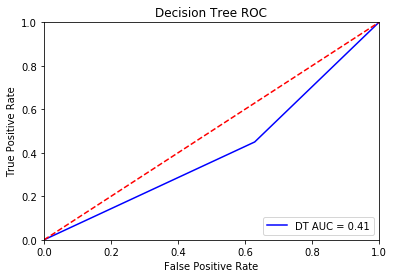

In [17]:
# ROC Curve
fpr, tpr, threshold = roc_curve(Y_test, dt_preds)
roc_auc = auc(fpr, tpr)

plt.title('Decision Tree ROC')
plt.plot(fpr, tpr, 'b', label = 'DT AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


## Step 7: Test other types of models

### Step 7a: Random Forest

In [18]:
n_trees = 20

rf = RandomForestClassifier(n_estimators=n_trees, random_state=0)

rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [19]:
# Make predictions on test set
rf_preds = rf.predict(X_test)

# Predict probabilities
rf_probs = rf.predict_proba(X_test)

In [20]:
# Confusion matrix
print(confusion_matrix(Y_test, rf_preds))

[[100  51]
 [ 80  40]]


In [21]:
print("Accuracy: %.2f percent" % np.multiply(100.0,accuracy_score(Y_test, rf_preds)))
print("Precision: %.2f percent" % np.multiply(100.0,precision_score(Y_test, rf_preds)))
print("Recall: %.2f percent" % np.multiply(100.0,recall_score(Y_test, rf_preds)))

Accuracy: 51.66 percent
Precision: 43.96 percent
Recall: 33.33 percent


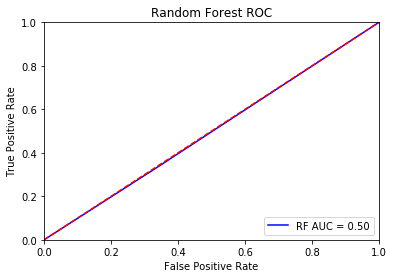

In [22]:
# ROC Curve
fpr, tpr, threshold = roc_curve(Y_test, rf_preds)
roc_auc = auc(fpr, tpr)

plt.title('Random Forest ROC')
plt.plot(fpr, tpr, 'b', label = 'RF AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


### Step 7b: Support Vector Machine

In [23]:
svm = SVC(kernel='rbf',probability=True, random_state=0)

svm.fit(X_train, Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False)

In [24]:
# Make predictions on test set
svm_preds = svm.predict(X_test)

# Predict probabilities
svm_probs = svm.predict_proba(X_test)

In [25]:
# Confusion matrix
print(confusion_matrix(Y_test, svm_preds))

[[131  20]
 [ 96  24]]


In [26]:
print("Accuracy: %.2f percent" % np.multiply(100.0,accuracy_score(Y_test, svm_preds)))
print("Precision: %.2f percent" % np.multiply(100.0,precision_score(Y_test, svm_preds)))
print("Recall: %.2f percent" % np.multiply(100.0,recall_score(Y_test, svm_preds)))

Accuracy: 57.20 percent
Precision: 54.55 percent
Recall: 20.00 percent


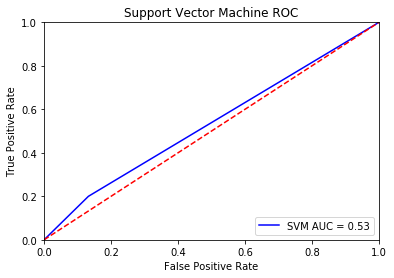

In [27]:
# ROC Curve
fpr, tpr, threshold = roc_curve(Y_test, svm_preds)
roc_auc = auc(fpr, tpr)

plt.title('Support Vector Machine ROC')
plt.plot(fpr, tpr, 'b', label = 'SVM AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


### Step 7c: Neural Network

In [28]:
nnet = MLPClassifier(random_state=0)

nnet.fit(X_train, Y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [29]:
# Make predictions on test set
nnet_preds = nnet.predict(X_test)

# Predict probabilities
nnet_probs = nnet.predict_proba(X_test)

In [30]:
# Confusion matrix
print(confusion_matrix(Y_test, nnet_preds))

[[59 92]
 [50 70]]


In [31]:
print("Accuracy: %.2f percent" % np.multiply(100.0,accuracy_score(Y_test, nnet_preds)))
print("Precision: %.2f percent" % np.multiply(100.0,precision_score(Y_test, nnet_preds)))
print("Recall: %.2f percent" % np.multiply(100.0,recall_score(Y_test, nnet_preds)))

Accuracy: 47.60 percent
Precision: 43.21 percent
Recall: 58.33 percent


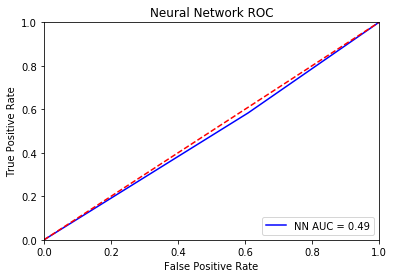

In [32]:
# ROC Curve
fpr, tpr, threshold = roc_curve(Y_test, nnet_preds)
roc_auc = auc(fpr, tpr)

plt.title('Neural Network ROC')
plt.plot(fpr, tpr, 'b', label = 'NN AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


### Step 7d: Summarize results

In [33]:
# Summarize results

models = ["Decision Tree", "Random Forest", "SVM", "Neural Network"]
precision_scores = []
recall_scores = []
accuracy_scores = []
auc_scores =[]

for preds in [dt_preds, rf_preds, svm_preds, nnet_preds]:
    precision_scores.append(precision_score(Y_test, preds))
    recall_scores.append(recall_score(Y_test, preds))
    accuracy_scores.append(accuracy_score(Y_test, preds))
    fpr, tpr, threshold = roc_curve(Y_test, preds)
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)
    
results = pd.DataFrame({"Accuracy" : accuracy_scores, "Precision" : precision_scores,  
                       "Recall" : recall_scores, "AUC" : auc_scores}, index=models)
    
results

,AUC,Accuracy,Precision,Recall
Decision Tree,0.410430,0.405904,0.362416,0.450000
Random Forest,0.497792,0.516605,0.439560,0.333333
SVM,0.533775,0.571956,0.545455,0.200000
Neural Network,0.487031,0.476015,0.432099,0.583333
